## Download dataset

#### machine translation dataset link http://www.manythings.org/anki/

In [1]:
!wget http://www.manythings.org/anki/spa-eng.zip
!unzip /content/spa-eng.zip -d "data"

--2021-05-24 04:56:17--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3031::6815:37de, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4934182 (4.7M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.71M  18.4MB/s    in 0.3s    

2021-05-24 04:56:17 (18.4 MB/s) - ‘spa-eng.zip’ saved [4934182/4934182]

Archive:  /content/spa-eng.zip
  inflating: data/_about.txt         
  inflating: data/spa.txt            


## Import libraries

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import re
from string import digits

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## Read dataset 

In [3]:
DATASET_PATH = '/content/data/spa.txt'

dataset = pd.read_table(DATASET_PATH, names=['source', 'target', 'comments'])

dataset.head()

dataset.tail()

dataset.shape

dataset.isnull().sum()

source      0
target      0
comments    0
dtype: int64

## Text Preprocessing

In [4]:
def preprocess_sentence(sentence):
    
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

def create_dataset(path, num_examples):
  
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  
  return zip(*word_pairs)

SAMPLE_SIZE = 60000
source, target, comments = create_dataset(DATASET_PATH, SAMPLE_SIZE)

len(source), len(target)

(60000, 60000)

## Tokenization

In [5]:
source_sent_tokenizer = Tokenizer(filters='')
source_sent_tokenizer.fit_on_texts(source)
source_sequences = source_sent_tokenizer.texts_to_sequences(source)
source_sequences = pad_sequences(source_sequences, padding='post', truncating='post')

target_sent_tokenizer = Tokenizer(filters='')
target_sent_tokenizer.fit_on_texts(target)
target_sequences = target_sent_tokenizer.texts_to_sequences(target)
target_sequences = pad_sequences(target_sequences, padding='post', truncating='post')

len(source_sequences[3]), len(target_sequences[3])

len(source_sent_tokenizer.word_index) + 1, len(target_sent_tokenizer.word_index) + 1

source_train, target_train, source_test, target_test = train_test_split(source_sequences, target_sequences, test_size=0.2)

len(source_train), len(target_train)

(48000, 12000)

## Create dataset in memory and make it as batches

In [6]:
BATCH_SIZE = 64

## create dataset in memory 
dataset = tf.data.Dataset.from_tensor_slices((source_sequences, target_sequences)).shuffle(BATCH_SIZE)

## shuffles the dataset in each batch 
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## create an iterator for a dataset generator
source_batch, target_batch = next(iter(dataset))

print(source_batch.shape)

print(target_batch.shape)

SOURCE_MAX_LEN = source_batch.shape[1]
TARGET_MAX_LEN = target_batch.shape[1]

(64, 13)
(64, 20)


## Building model

In [7]:
## setting few parameters for model building

BUFFER_SIZE = len(source_sequences)
STEPS_PER_EPOCH = len(source_sequences) // BATCH_SIZE
EMBEDDING_DIM = 256
UNITS = 1024
SOURCE_VOCAB_SIZE = len(source_sent_tokenizer.word_index) + 1
TARGET_VOCAB_SIZE = len(target_sent_tokenizer.word_index) + 1

In [8]:
## create Encoder
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.encoder_units = encoder_units
    self.embedding_layer = Embedding(vocab_size, embedding_dim)
    self.gru_layer = GRU(units=encoder_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')


  def call(self, x, hidden):
    ## pass input x to embedding layer
    x = self.embedding_layer(x)
    ## pass embedding and hidden layer to gru
    output, state = self.gru_layer(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.encoder_units))
    

In [9]:
## testing encoder class
encoder = Encoder(SOURCE_VOCAB_SIZE, EMBEDDING_DIM, UNITS, BATCH_SIZE)
sample_hidden_state = encoder.initialize_hidden_state()
sample_output, sample_state = encoder.call(source_batch, sample_hidden_state)

In [10]:
sample_hidden_state.shape, sample_output.shape, sample_state.shape

(TensorShape([64, 1024]), TensorShape([64, 13, 1024]), TensorShape([64, 1024]))

In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super( BahdanauAttention, self).__init__()
        self.W1= tf.keras.layers.Dense(units)  # encoder output
        self.W2= tf.keras.layers.Dense(units)  # Decoder hidden
        self.V= tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        #calculate the Attention score
        hidden_with_time_axis = tf.expand_dims(query , 1)
        score= self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights= tf.nn.softmax(score, axis=1)
        
         #context_vector 
        context_vector= attention_weights * values
       
        #Computes the sum of elements across dimensions of a tensor
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


## testing attention classs
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden_state, sample_output)

attention_result.shape, attention_weights.shape

(TensorShape([64, 1024]), TensorShape([64, 13, 1]))

In [12]:
## creating decoder layer
class Decoder(Model):
  def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.decoder_units = decoder_units
    self.embedding_layer = Embedding(vocab_size, embedding_dim)
    self.gru = GRU(decoder_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    ## fully connected layer
    self.fc = Dense(vocab_size)

    ## attention
    self.attention = BahdanauAttention(self.decoder_units)

  def call(self, x, hidden, encoder_output):
    ## x : previous time stamp decoder output
    ## hidden : previous time stamp decoder hidden state values
    ## encoder_output : context vectors
    context_vector, attention_weights = self.attention(hidden, encoder_output)

    ## pass decoder outputs to input layers
    x = self.embedding_layer(x)

    ## concanate context vector and embedding layer 
    x = tf.concat([tf.expand_dims(context_vector, 1,), x], axis=-1)

    ## pass expand vector values through gru layer
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [13]:
decoder= Decoder(TARGET_VOCAB_SIZE, EMBEDDING_DIM, UNITS, BATCH_SIZE)
sample_decoder_output, _, _= decoder(tf.random.uniform((BATCH_SIZE,1)), sample_hidden_state, sample_output)

In [14]:
sample_decoder_output.shape

TensorShape([64, 15349])

In [15]:
from tensorflow.keras.optimizers import Adam

In [16]:
## define optimizer for the model
optimizer = Adam()

In [17]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [18]:
## define loss function
loss = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [19]:
def loss_function(real, predict):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss(real, predict)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [20]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [21]:
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_sent_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [22]:
STEPS_PER_EPOCH

937

In [23]:
import time

In [24]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(STEPS_PER_EPOCH)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / STEPS_PER_EPOCH))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 1.7169357538223267
Epoch 1 Batch 100 loss 1.229379415512085
Epoch 1 Batch 200 loss 1.2609665393829346
Epoch 1 Batch 300 loss 1.4875595569610596
Epoch 1 Batch 400 loss 1.4921621084213257
Epoch 1 Batch 500 loss 1.4622085094451904
Epoch 1 Batch 600 loss 1.6958038806915283
Epoch 1 Batch 700 loss 1.5350778102874756
Epoch 1 Batch 800 loss 1.7056175470352173
Epoch 1 Batch 900 loss 1.630702257156372
Epoch 1 Loss 1.4824
Time taken for 1 epoch 390.643390417099 sec

Epoch 2 Batch 0 loss 1.0139509439468384
Epoch 2 Batch 100 loss 0.9436687231063843
Epoch 2 Batch 200 loss 1.031219244003296
Epoch 2 Batch 300 loss 1.2537111043930054
Epoch 2 Batch 400 loss 1.2135181427001953
Epoch 2 Batch 500 loss 1.1552131175994873
Epoch 2 Batch 600 loss 1.4224622249603271
Epoch 2 Batch 700 loss 1.3227927684783936
Epoch 2 Batch 800 loss 1.3510061502456665
Epoch 2 Batch 900 loss 1.3745700120925903
Epoch 2 Loss 1.1719
Time taken for 1 epoch 384.6766414642334 sec

Epoch 3 Batch 0 loss 0.9077828526496

## Evaluation

In [25]:
max_target_length= max(len(t) for t in  target_sequences)
print(max_target_length)
max_source_length= max(len(t) for t in  source_sequences)
print(max_source_length)

20
13


In [26]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocess_sentence(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = [source_sent_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, UNITS))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sent_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sent_tokenizer.index_word[predicted_id] + ' '

    if target_sent_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [27]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [28]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [29]:
import matplotlib.ticker as ticker

Input: start_ how are you ? _end
Predicted translation: ¿ cómo estás ? _end 


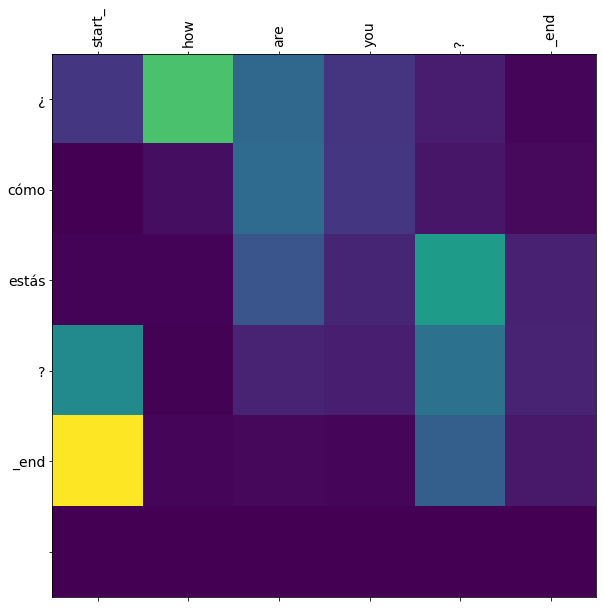

In [30]:
translate(u'How are you?')

Input: start_ i am going to work . _end
Predicted translation: voy a trabajar . _end 


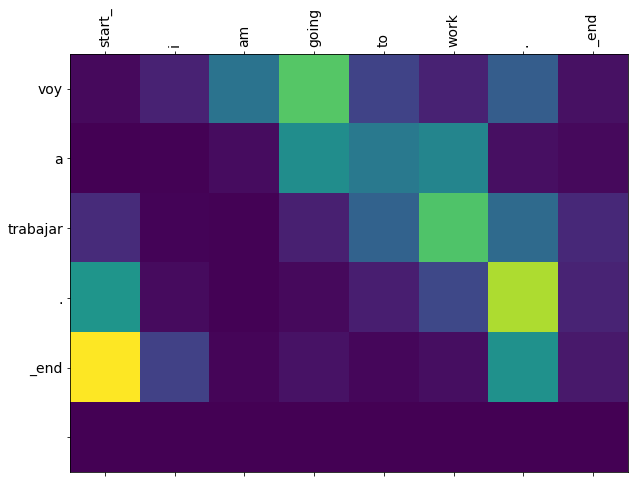

In [31]:
translate(u'I am going to work.')